### Setup

In [ ]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import pickle 
import torch as th
import torch.nn.functional as F
import torch
import networkx as nx
import pandas as pd
import numpy as np

import torch_geometric
from torch_geometric.explain import Explainer, CaptumExplainer, DummyExplainer, GNNExplainer
from torch_geometric.explain.metric import *
from torch_geometric.nn.models.basic_gnn import GraphSAGE
from torch_geometric.utils import from_dgl
from tqdm import tqdm
from torch_geometric.explain import ModelConfig
from torch_geometric.data import Data

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


device(type='cpu')

In [9]:
import pickle 

with open('../../interm/label_encoders.pkl', 'rb') as f:
    le = pickle.load(f) 
    
target_encoder = le['Attack']
print(le)

{'L7_PROTO': LabelEncoder(), 'ICMP_TYPE': LabelEncoder(), 'ICMP_IPV4_TYPE': LabelEncoder(), 'DNS_QUERY_TYPE': LabelEncoder(), 'FTP_COMMAND_RET_CODE': LabelEncoder(), 'Attack': LabelEncoder()}


In [ ]:
import dgl
import numpy as np
import scienceplots

def get_batch(data, batch_size=5000):
    all_data = data.copy()
    while len(all_data) > 0:
        if len(all_data) >= batch_size:
            batch = all_data.sample(batch_size)
            all_data = all_data.drop(batch.index)
            yield batch
        else:
            batch = all_data.copy()
            all_data = all_data.drop(batch.index)
            yield batch


def to_graph(data):
    G = nx.from_pandas_edgelist(data, source='src', 
                                target='dst', 
                                edge_attr=['x', 'Attack'], 
                                create_using=nx.MultiGraph())
    
    G = G.to_directed()
    g = dgl.from_networkx(G, edge_attrs=[ 'x', 'Attack'])
    g = g.line_graph(shared=True)
    return from_dgl(g) 


def masked_prediction(mask, model, G, hardmask=True):
    if not hardmask:
        inv_mask = 1-mask
    else:
        inv_mask = ~mask
        
    y_pred = model(G.x, G.edge_index).argmax(axis=1)
    ym_pred = model(G.x*mask, G.edge_index).argmax(axis=1)
    ymi_pred = model(G.x*inv_mask, G.edge_index).argmax(axis=1)
    return y_pred, ym_pred, ymi_pred


def fidelities(y_pred, y_mask, y_imask, y):
    fn = ((y_pred == y).float() - (y_mask == y).float()).abs().mean()
    fp = ((y_pred == y).float() - (y_imask == y).float()).abs().mean()
    return fp, fn


        
def plot_sparsity_curves(metrics_list, legend=None, s=3):
    # plt.style.use(['science','no-latex'])
    with plt.style.context('science'): 
           
        for metrics in metrics_list:
            plt.plot(metrics['s'], metrics['fid-'])
            plt.scatter(metrics['s'], metrics['fid-'], s=s)
        
        plt.title('Sparsity Vs Fidelity-')
        if legend: plt.legend(legend)
        plt.show()
        
        for metrics in metrics_list:
            plt.plot(metrics['s'], metrics['fid+'])
            plt.scatter(metrics['s'], metrics['fid+'], s=s)
        
        plt.title('Sparsity Vs Fidelity+')
        if legend: plt.legend(legend)
        plt.show()
        
        for metrics in metrics_list:
            plt.plot(metrics['s'], metrics['c'])
            plt.scatter(metrics['s'], metrics['c'], s=s)
        
        plt.title('Sparsity Vs Characterisation Score')
        if legend: plt.legend(legend)
        plt.show()

In [17]:
test = pd.read_csv('../../interm/BoT_test.csv')
test = test.drop([c for c in test.columns if c.endswith('_metadata')], axis=1)
attrs = [c for c in test.columns if c not in ("src", "dst", "Attack", "x")]
test['x'] = test[attrs].values.tolist()

len(test['x'][0])


49

In [19]:
model = GraphSAGE(
    49,
    hidden_channels=256,
    out_channels=5,
    num_layers=3,
).to(device)

model.load_state_dict(th.load('../../interm/GraphSAGE_BoTIoT.pth'))
model.eval()

/tmp/ipykernel_85493/2437329591.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(th.load('../../interm/GraphSAGE_BoTIoT.pth'))


GraphSAGE(49, 5, num_layers=3)

In [20]:
from sklearn.metrics import classification_report

G = to_graph(test)
y_pred = model(G.x, G.edge_index)
y_pred = y_pred = torch.argmax(y_pred, dim=1)
y_true = G.Attack

print(
    classification_report(y_true, y_pred)
)

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     22668
           1       0.72      0.79      0.75      2156
           2       0.76      0.68      0.72      2108
           3       0.99      0.91      0.95      2096
           4       1.00      1.00      1.00       732

    accuracy                           0.96     29760
   macro avg       0.89      0.88      0.88     29760
weighted avg       0.96      0.96      0.96     29760



### DummyExplainer

$mask \sim U(0, 1)$

In [ ]:
explainer = Explainer(
    model=model,
    algorithm=DummyExplainer(),
    explanation_type='phenomenon',
    node_mask_type='attributes',
    edge_mask_type=None,
    model_config=ModelConfig(
        mode='multiclass_classification',
        task_level='node',
        return_type='raw',
    ),
)  
explanation = explainer(
        x=G.x.to(device),
        edge_index=G.edge_index.to(device),
        target=G.Attack,
)

In [ ]:
import copy

de_metrics = {'fid+': [], 'fid-': [], 's': [], 'c': [], 'k': []}

explanation_cp = copy.deepcopy(explanation)

# vary sparsity
for s in tqdm(np.arange(0.1, 1, 0.1)):
    flat_mask = explanation.node_mask.flatten()
    k = int(s * flat_mask.numel())
    threshold = torch.topk(flat_mask, k).values[-1]
    
    new_mask = (explanation.node_mask >= threshold).float()
    explanation_cp.node_mask = new_mask
    
    fp, fn = fidelity(explainer, explanation_cp)
    de_metrics['fid+'].append(fp)
    de_metrics['fid-'].append(fn)
     
    c = characterization_score(fp, fn) if (fp * fn) != 0 else 0
    de_metrics['c'].append(c)
    de_metrics['s'].append(s)
    de_metrics['k'].append(k)

  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 9/9 [01:13<00:00,  8.15s/it]


In [ ]:
from torch_geometric.explain.metric import fidelity, characterization_score

# softmask over full graph
de_metrics['softmask fidelity'] = fidelity(explainer, explanation)

In [ ]:
# softmask over each attack category 
y_pred, ym_pred, ymi_pred = masked_prediction(
    explanation.node_mask, model, G, hardmask=False)

for idx in range(y_pred.max()):
    attack = target_encoder.inverse_transform([idx])[0]
    fp, fn = fidelities(y_pred= y_pred == idx, 
                        y_mask= ym_pred == idx, 
                        y_imask= ymi_pred == idx,
                        y= G.Attack==idx)

    w = (G.Attack==idx).float().mean()
    c = characterization_score(fp, fn, pos_weight=w, neg_weight=1-w) if fp*fn > 0 else 0
    
    de_metrics[f'softmask fidelity {attack}'] = fp, fn, c
     
de_metrics

{'fid+': [0.05645161122083664,
  0.09002016484737396,
  0.1328629106283188,
  0.15567876398563385,
  0.1683131754398346,
  0.18040995299816132,
  0.19176746904850006,
  0.1965389847755432,
  0.19264112412929535],
 'fid-': [0.19139784574508667,
  0.19637097418308258,
  0.1920698881149292,
  0.1796370893716812,
  0.16609543561935425,
  0.15235215425491333,
  0.13282930850982666,
  0.09264113008975983,
  0.057426076382398605],
 's': [np.float64(0.1),
  np.float64(0.2),
  np.float64(0.30000000000000004),
  np.float64(0.4),
  np.float64(0.5),
  np.float64(0.6),
  np.float64(0.7000000000000001),
  np.float64(0.8),
  np.float64(0.9)],
 'c': [0.10553539274920122,
  0.1619042866841241,
  0.22819885709300317,
  0.2616959649736005,
  0.28009307691923224,
  0.2975009930313378,
  0.3140790179013196,
  0.32309400795058807,
  0.3199015033865889],
 'k': [145824,
  291648,
  437472,
  583296,
  729120,
  874944,
  1020768,
  1166592,
  1312416],
 'softmask fidelity': (0.0990927442908287, 0.099663980305

### GNNExplainer

- Finds $M* = argmax_M \space MI(Y; G_M) \quad MI(Y; G) = H(Y|G) - H(Y|G_S)$
- By minimizing $L(M,E) = -log P(y|G_s) + \lambda_1||M||_1$  with gradient descent on $M$

In [28]:
G.x.shape, G.edge_index.shape

(torch.Size([29760, 49]), torch.Size([2, 5405122]))

In [54]:
for attack, subG in yield_class_graphs(G):
    print(f'{attack}: g.x.shape = {subG.x.shape}, g.edge_index.shape: {subG.edge_index.shape:}')
    print(subG.Attack.unique())
    print([(subG.Attack == i).sum() for i in subG.Attack.unique()])

Benign: g.x.shape = torch.Size([22668, 49]), g.edge_index.shape: torch.Size([2, 2256682])
tensor([0])
[tensor(22668)]
DDoS: g.x.shape = torch.Size([24824, 49]), g.edge_index.shape: torch.Size([2, 3203310])
tensor([0, 1])
[tensor(22668), tensor(2156)]
DoS: g.x.shape = torch.Size([24776, 49]), g.edge_index.shape: torch.Size([2, 3159640])
tensor([0, 2])
[tensor(22668), tensor(2108)]
Reconnaissance: g.x.shape = torch.Size([24764, 49]), g.edge_index.shape: torch.Size([2, 2490326])
tensor([0, 3])
[tensor(22668), tensor(2096)]
Theft: g.x.shape = torch.Size([23400, 49]), g.edge_index.shape: torch.Size([2, 2294726])
tensor([0, 4])
[tensor(22668), tensor(732)]


In [ ]:
import copy

gnne_explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(10),
    # explanation_type='model',
    explanation_type='phenomenon',
    node_mask_type='attributes',
    edge_mask_type=None,
    model_config=ModelConfig(
        mode='multiclass_classification',
        task_level='node',
        return_type='raw',
    ),
)  


def yield_class_graphs(G):
    benign_idx =  le['Attack'].transform(['Benign'])
    for attack in le['Attack'].classes_:
        idx = le['Attack'].transform([attack])

        mask = (G.Attack == idx) | (G.Attack == benign_idx)
        node_idx = mask.nonzero(as_tuple=True)[0]
        edge_index, _ = torch_geometric.utils.subgraph(
            node_idx,
            G.edge_index,
            relabel_nodes=True,
        )
        
        subG = Data(
            x=G.x[node_idx],
            edge_index=edge_index,
            Attack=G.Attack[node_idx]
        )
        
        yield attack, subG
        
        
gnne_explanations = {}
gnne_metrics = {}

for attack, subG in yield_class_graphs(G):
    if attack == 'Benign': 
        continue
    
    print(f'{attack}: g.x.shape = {subG.x.shape}, g.edge_index.shape: {subG.edge_index.shape:}')
    
    gnne_explanations[attack] = explanation = gnne_explainer(
        x=subG.x.to(device),
        edge_index=subG.edge_index.to(device),
        target=subG.Attack,
    )
    
    #  TODO: raw metrics aswell 
    
    fp, fn = fidelity(gnne_explainer, explanation)
    c = characterization_score(fp, fn) if (fp * fn) != 0 else 0
    gnne_metrics[f'{attack} softmask metrics'] = fp, fn, c
    print(f'\tfp: {fp:.3f}')
    print(f'\tfn: {fn:.3f}')
    print(f'\tc: {c:.3f}')
    
    sparsity_curve = {'fid+': [], 'fid-': [], 's': [], 'c': [], 'k': []}
    explanation_cp = copy.deepcopy(explanation)
    
    for s in tqdm(np.arange(0.1, 1, 0.1)):
        
        flat_mask = explanation.node_mask.flatten()
        k = int(s * flat_mask.numel())
        threshold = torch.topk(flat_mask, k).values[-1]
        
        new_mask = (explanation.node_mask >= threshold).float()
        explanation_cp.node_mask = new_mask
        
        fp, fn = fidelity(explainer, explanation_cp)
        sparsity_curve['fid+'].append(fp)
        sparsity_curve['fid-'].append(fn)
        
        c = characterization_score(fp, fn) if (fp * fn) != 0 else 0
        sparsity_curve['c'].append(c)
        sparsity_curve['s'].append(s)
        sparsity_curve['k'].append(k)
        
        
    gnne_metrics[f'{attack} sparsity curve'] = sparsity_curve
    del explanation_cp
    
    # !! mode=binary_classification may only consider the 'on' nodes for the explanation mask ( !! required)
    # !! sparsity etc con be computerd with pyG, read the docs

DDoS: g.x.shape = torch.Size([24824, 49]), g.edge_index.shape: torch.Size([2, 3203310])
	fp: 0.024
	fn: 0.010
	c: 0.046


100%|██████████| 9/9 [00:43<00:00,  4.79s/it]


DoS: g.x.shape = torch.Size([24776, 49]), g.edge_index.shape: torch.Size([2, 3159640])
	fp: 0.011
	fn: 0.007
	c: 0.022


100%|██████████| 9/9 [00:40<00:00,  4.53s/it]


Reconnaissance: g.x.shape = torch.Size([24764, 49]), g.edge_index.shape: torch.Size([2, 2490326])
	fp: 0.000
	fn: 0.001
	c: 0.001


100%|██████████| 9/9 [00:36<00:00,  4.07s/it]


Theft: g.x.shape = torch.Size([23400, 49]), g.edge_index.shape: torch.Size([2, 2294726])
	fp: 0.000
	fn: 0.000
	c: 0.001


100%|██████████| 9/9 [00:30<00:00,  3.35s/it]


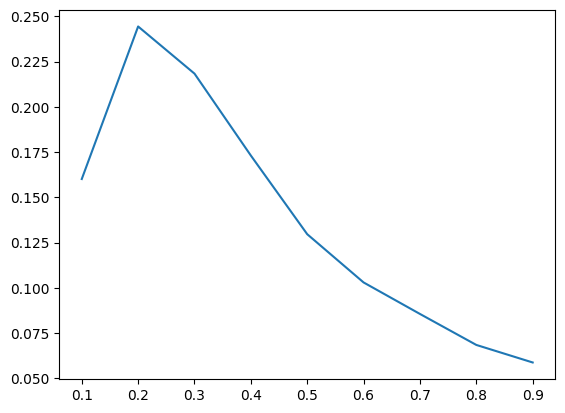

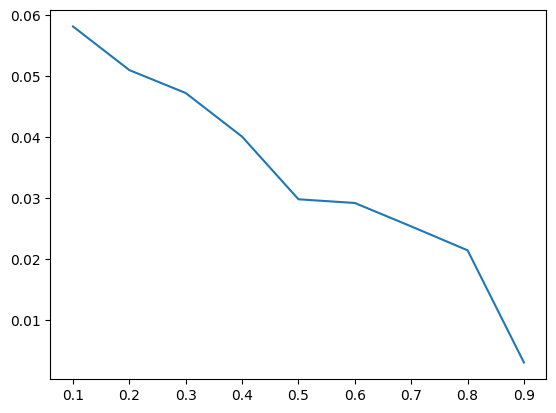

In [58]:
c = gnne_metrics['DoS sparsity curve']
plt.plot(c['s'], c['fid+']); plt.show()
plt.plot(c['s'], c['fid-']); plt.show()

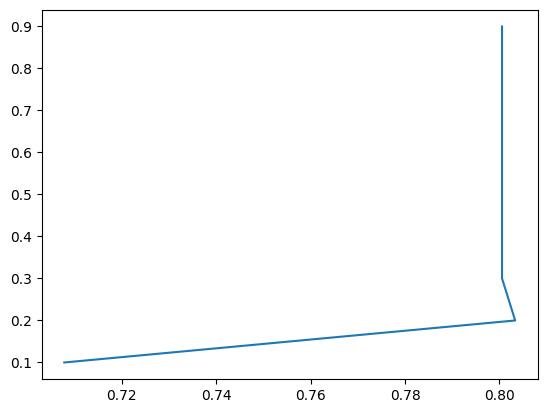

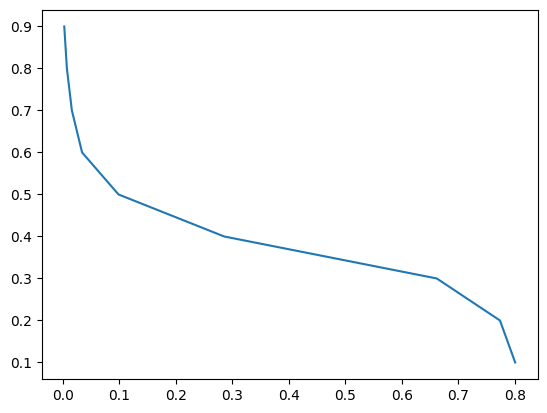

In [42]:
c = gnne_metrics['DDoS sparsity curve']
plt.plot(c['fid+'], c['s']); plt.show()
plt.plot(c['fid-'], c['s']); plt.show()

### IntegratedGradients
$$
\mathrm{IG}(x_v) = (x_v - x'_v) \odot \int_{0}^{1} \nabla_{x_v} F\!\big(x'_{v} + \alpha (x_v - x'_v), \, G\big) \, d\alpha
$$

In [14]:
import torch
from tqdm import tqdm

def integrated_gradients(x, edge_index, model, steps, baseline):
    device = x.device
    if baseline is None:
        baseline = torch.zeros_like(x, device=device)

    diff = x - baseline
    total_grads = torch.zeros_like(x, device=device)

    for alpha in tqdm(torch.linspace(0.0, 1.0, steps, device=device)):
        x_scaled = baseline + alpha * diff
        x_scaled.requires_grad_(True)

        # forward pass
        out = model(x_scaled, edge_index)
        
        # pick the logit for each root node & assume root nodes are first B rows
        # batch_size = targets.size(0)
        # sel = out[:batch_size, :] 
        # chosen = sel[torch.arange(batch_size), targets]

        # sum to get a scalar and backprop
        model.zero_grad()
        torch.autograd.backward(out.sum(), retain_graph=True)
        grads = x_scaled.grad

        total_grads += grads
        x_scaled.grad.zero_()

    # average gradient then scale by input delta
    avg_grads = total_grads / steps
    attributions = diff * avg_grads 

    return attributions


model.eval()
ig_attr = integrated_gradients(
    x=G.x,
    edge_index=G.edge_index,
    # targets=targets,
    model=model,
    baseline=torch.zeros_like(G.x),
    steps=100
)


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [07:09<00:00,  4.30s/it]


In [17]:
import copy
from torch_geometric.explain.metric import fidelity, characterization_score

ig_metrics = {'fid+': [], 'fid-': [], 's': [], 'c': [], 'k': []}

def manual_fidelities(mask, hardmask=True):
    if not hardmask:
        inv_mask = 1-mask
    else:
        inv_mask = ~mask
        
    y_pred = model(G.x, G.edge_index).argmax(axis=1)
    ym_pred = model(G.x*mask, G.edge_index).argmax(axis=1)
    ymi_pred = model(G.x*(inv_mask), G.edge_index).argmax(axis=1)
    y = G.Attack
    
    # fid_plus = (np.array(y_pred == y, dtype=int) - np.array(ym_pred == y, dtype=int)).mean() 
    # fid_minus = (np.array(y_pred == y, dtype=int) - np.array(ymi_pred == y, dtype=int)).mean() 
    pos_fidelity = (
        (y_pred == y).float() - (ymi_pred == y).float()).abs().mean()
    neg_fidelity = (
        (y_pred == y).float() - (ym_pred == y).float()).abs().mean()
        
    return pos_fidelity, neg_fidelity

mx, mn = ig_attr.max(), ig_attr.min()
ig_soft_mask = (ig_attr - mn) / (mx + mn)
f = manual_fidelities(ig_soft_mask, hardmask=False) 
ig_metrics['softmask fidelity'] = f
f

(tensor(0.0101), tensor(0.3415))

In [ ]:
## Top K features 
for s in tqdm(np.arange(0.1, 1, 0.1)):
    
    flat_mask = ig_soft_mask.flatten()
    k = int(s * flat_mask.numel())
    threshold = torch.topk(flat_mask, k).values[-1]
    
    hard_mask = (ig_soft_mask >= threshold).bool()
    fp, fn = manual_fidelities(hard_mask)
    
    ig_metrics['fid+'].append(fp)
    ig_metrics['fid-'].append(fn)
    
    # c = characterization_score(fp, fn) if (fp * fn) != 0 else 0
    ig_metrics['c'].append(c)
    ig_metrics['s'].append(s)
    ig_metrics['k'].append(k)
   

  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 9/9 [01:12<00:00,  8.09s/it]


### GraphMask

In [36]:
from torch_geometric.explain.algorithm import GraphMaskExplainer

model_config = ModelConfig(
    mode='multiclass_classification',
    task_level='node',
    return_type='raw'
)

explainer = Explainer(
    model=model,
    algorithm=GraphMaskExplainer(3, epochs=5),
    explanation_type='phenomenon', 
    model_config=model_config,
    node_mask_type='attributes',
    edge_mask_type='object',
)

explanations = []
for batch in tqdm(get_batch(test, batch_size=5_000)):
    batched_G = to_graph(batch)
    explanation = explainer(batched_G.x, 
                            batched_G.edge_index, 
                            target=batched_G.Attack)
    
    explanations.append(explanation)
    print(explanation)


0it [00:00, ?it/s]

Explain: 100%|██████████| 3/3 [00:02<00:00,  1.45it/s]
1it [01:19, 79.88s/it]

Explanation(node_mask=[10000, 49], edge_mask=[626812], target=[10000], x=[10000, 49], edge_index=[2, 626812])


Explain: 100%|██████████| 3/3 [00:01<00:00,  1.51it/s]
2it [02:37, 78.37s/it]

Explanation(node_mask=[10000, 49], edge_mask=[613714], target=[10000], x=[10000, 49], edge_index=[2, 613714])


Explain: 100%|██████████| 3/3 [00:01<00:00,  1.58it/s]
3it [03:50, 76.71s/it]

Explanation(node_mask=[9760, 49], edge_mask=[579250], target=[9760], x=[9760, 49], edge_index=[2, 579250])


In [38]:
from torch_geometric.explain.metric import fidelity

gm_metrics = {'fid+': [], 'fid-': [], 's': [], 'c': [], 'k': []}


def get_masked_prediction(sparsity, explanations):
    l = {'y': [], 'yp': [], 'ypm': [], 'ypmi': []}
    for batch, expl in zip(get_batch(test, batch_size=5_000), explanations):
        
        # sparsity restriction is computed per-batch
        # due to memory limitations
        soft_mask = expl.node_mask
        flat_mask = soft_mask.flatten()
        k = int(sparsity * flat_mask.numel())
        threshold = torch.topk(flat_mask, k).values[-1]
        mask = soft_mask > threshold
        
        batch_G = to_graph(batch)
        l['y'].append(batch_G.Attack)
        l['yp'].append(model(batch_G.x, batch_G.edge_index).argmax(axis=1))
        l['ypm'].append(model(batch_G.x * mask, batch_G.edge_index).argmax(axis=1))
        l['ypmi'].append(model(batch_G.x * (~mask), batch_G.edge_index).argmax(axis=1))

    y, y_pred, y_mask, y_imask = [
        np.concat(l) 
        for l in (l['y'], l['yp'], l['ypm'], l['ypmi'])
    ]
    fidm = np.abs(((y_pred == y).astype(float) - (y_mask == y)).astype(float)).mean()
    fidp = np.abs(((y_pred == y).astype(float) - (y_imask == y)).astype(float)).mean()
    return fidp, fidm

        
for s in tqdm(np.arange(0.1, 1, 0.1)):
    fn, fp = get_masked_prediction(s, explanations=explanations)    
    gm_metrics['fid+'].append(fp)
    gm_metrics['fid-'].append(fn)
    c = characterization_score(fp, fn) if (fp * fn) != 0 else 0
    gm_metrics['c'].append(c)
    gm_metrics['s'].append(s)

  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 9/9 [00:45<00:00,  5.01s/it]


In [39]:
gm_metrics['softmask fidelity'] = fidelity(explainer, explanation)

y_pred, ym_pred, ymi_pred = masked_prediction(
    explanation.node_mask, model, G, hardmask=False)

for idx in range(y_pred.max()):
    attack = target_encoder.inverse_transform([idx])[0]
    fp, fn = fidelities(y_pred= y_pred == idx, 
                        y_mask= ym_pred == idx, 
                        y_imask= ymi_pred == idx,
                        y= G.Attack==idx)

    w = (G.Attack==idx).float().mean()
    c = characterization_score(fp, fn, pos_weight=w, neg_weight=1-w) if fp*fn > 0 else 0
    
    gm_metrics[f'softmask fidelity {attack}'] = fp, fn, c

RuntimeError: The size of tensor a (29760) must match the size of tensor b (9760) at non-singleton dimension 0

### PGExplainer

In [10]:
from torch_geometric.explain import Explainer, ModelConfig
from torch_geometric.explain.algorithm import PGExplainer
from torch_geometric.utils import k_hop_subgraph
import torch, gc

model_config = ModelConfig(
    task_level='node',
    mode='multiclass_classification',
    return_type='probs',
)

explainer = Explainer(
    model=model,
    algorithm=PGExplainer(epochs=5, lr=0.01),
    explanation_type='phenomenon',
    edge_mask_type='object',
    model_config=model_config,
)

def train_epoch(trainer_function, epoch):
    for batch in get_batch(test, batch_size=5_000):
        batched_G = to_graph(batch)
        losses = []
        for i in tqdm(range(len(batched_G.x))):
            losses.append(
                trainer_function(epoch, model, batched_G.x, 
                                 batched_G.edge_index, 
                                 target=batched_G.Attack, index=i))
        
        print(f'av loss: {losses.mean()}')


# Train against a variety of node-level or graph-level predictions:
for epoch in range(30):
    train_epoch(explainer.algorithm.train, epoch=epoch)
    

  0%|          | 36/10000 [00:50<3:51:50,  1.40s/it]


KeyboardInterrupt: 

In [ ]:
# explanations = []
# for batch in tqdm(get_batch(test, batch_size=5_000)):
#     batched_G = to_graph(batch)
#     explanation = explainer(batched_G.x, 
#                             batched_G.edge_index, 
#                             target=batched_G.Attack)
    
#     explanations.append(explanation)
#     print(explanation)

### Results

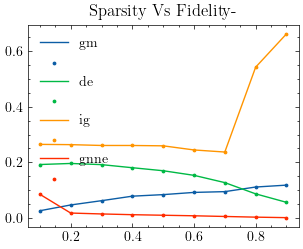

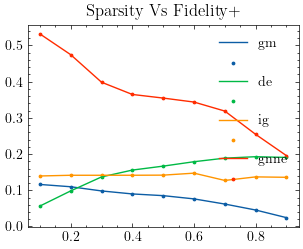

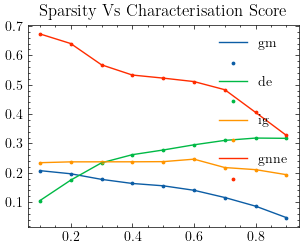

In [38]:
plot_sparisity_curves([
    gm_metrics, 
    de_metrics, 
    ig_metrics,
    gnne_metrics,
    
], legend=('gm', '', 'de', '', 'ig', '', 'gnne', ''), s=3)

In [ ]:
# TODO: per-class metrics
for name, metric in zip(('de', 'gnne', 'gm', 'de', 'ig'), 
                        (de_metrics, gnne_metrics, 
                        gm_metrics, de_metrics, ig_metrics)):
    
    print(name + " softmask:")
    fp, fn = metric['softmask fidelity']
    c=  characterization_score(fp, fn) if fp*fn > 0 else 0
    print(f' fidelity+ {fp:.4f}\n fidelity- {fn:.4f}\n characterisation {c:.4f}\n')

de softmask:
 fidelity+ 0.1016
 fidelity- 0.0997
 characterisation 0.1826

gnne softmask:
 fidelity+ 0.0655
 fidelity- 0.0243
 characterisation 0.1227

gm softmask:
 fidelity+ 0.0724
 fidelity- 0.0712
 characterisation 0.1344

de softmask:
 fidelity+ 0.1016
 fidelity- 0.0997
 characterisation 0.1826

ig softmask:
 fidelity+ 0.0101
 fidelity- 0.3415
 characterisation 0.0200

